# Week 7 - Information Extraction


This week, we move from arbitrary textual classification to the use of computation and linguistic models to parse precise claims from documents. Rather than focusing on simply the *ideas* in a corpus, here we focus on understanding and extracting its precise *claims*. This process involves a sequential pipeline of classifying and structuring tokens from text, each of which generates potentially useful data for the content analyst. Steps in this process, which we examine in this notebook, include: 1) tagging words by their part of speech (POS) to reveal the linguistic role they play in the sentence (e.g., Verb, Noun, Adjective, etc.); 2) tagging words as named entities (NER) such as places or organizations; 3) structuring or "parsing" sentences into nested phrases that are local to, describe or depend on one another; and 4) extracting informational claims from those phrases, like the Subject-Verb-Object (SVO) triples we extract here. While much of this can be done directly in the python package NLTK that we introduced in week 2, here we use NLTK bindings to the Stanford NLP group's open software, written in Java. Try typing a sentence into the online version [here]('http://nlp.stanford.edu:8080/corenlp/') to get a sense of its potential. It is superior in performance to NLTK's implementations, but takes time to run, and so for these exercises we will parse and extract information for a very small text corpus. Of course, for final projects that draw on these tools, we encourage you to install the software on your own machines or shared servers at the university (RCC, SSRC) in order to perform these operations on much more text. 

For this notebook we will be using the following packages:

# Setup

In [54]:
#All these packages need to be installed from pip
#For NLP
import nltk
from nltk.tag import StanfordNERTagger
from nltk.tag import StanfordPOSTagger
from nltk.parse import stanford
from nltk.tokenize import word_tokenize
from nltk.tree import Tree
from nltk.draw.tree import TreeView
from nltk.tokenize import sent_tokenize
import sklearn

import numpy as np #For arrays
import pandas #Gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import seaborn #Makes the graphics look nicer
import pandas as pd # I don't want to write 'pandas' all the fucking time

#Displays the graphs
import graphviz #You also need to install the command line graphviz

#These are from the standard library
import os.path
import zipfile
import subprocess
import io
import tempfile

%matplotlib inline

If you want to use the [Stanford NLP group](http://nlp.stanford.edu/) programs with nltk on your own machine (you do *not* need to do this for this assignment), it will require a little bit of setup. We are basing these instructions on those provided by nltk, [here](https://github.com/nltk/nltk/wiki/Installing-Third-Party-Software#stanford-tagger-ner-tokenizer-and-parser), but with small changes to work with our notebooks. We also note that lower performance versions of many of the techniques demonstrated here are available natively within nltk (see the updated [nltk book](http://www.nltk.org/book/)).

1. Install [Java 1.8+](http://www.oracle.com/technetwork/java/javase/downloads/jdk8-downloads-2133151.html)
    + Make sure your `JAVAPATH` is setup if you're on windows
2. Download the following zip files from the Stanford NLP group, where DATE is the release date of the files, this will be the value of `stanfordVersion`
    + [`stanford-corenlp-full-2016-10-31.zip`](https://stanfordnlp.github.io/CoreNLP/)
    + [`stanford-postagger-full-DATE.zip`](http://nlp.stanford.edu/software/tagger.html#Download)
    + [`stanford-ner-DATE.zip`](http://nlp.stanford.edu/software/CRF-NER.html#Download)
    + [`stanford-parser-full-DATE.zip`](http://nlp.stanford.edu/software/lex-parser.html#Download)
3. Unzip the files and place the resulting directories in the same location, this will become `stanfordDir`
4. Lookup the version number used by the parser `stanford-parser-VERSION-models.jar` and set to to be `parserVersion`

In [55]:
#This is the date at the end of each of the zip files, e.g.
#the date in stanford-ner-2016-10-31.zip
stanfordVersion = '2016-10-31'

#This is the version numbers of the parser models, these
#are files in `stanford-parser-full-2016-10-31.zip`, e.g.
#stanford-parser-3.7.0-models.jar
parserVersion = '3.7.0'

#This is where the zip files were unzipped.Make sure to
#unzip into directories named after the zip files
#Don't just put all the files in `stanford-NLP`
try:
    # Because the server for this class is like having an air conditioning powered by 
    # an asthmatic blowing at you with a straw.
    stanfordDir = '/home/jmcclellan/stanford-NLP'
except:
    stanfordDir = '/mnt/efs/resources/shared/stanford-NLP'
    

#Parser model, there are a few for english and a couple of other languages as well
modelName = 'englishPCFG.ser.gz'

We now will initialize all the tools

Setting up [NER tagger](http://www.nltk.org/api/nltk.tag.html?highlight=stanfordpostagger#nltk.tag.stanford.StanfordNERTagger)

In [56]:
nerClassifierPath = os.path.join(stanfordDir,'stanford-ner-{}'.format(stanfordVersion), 'classifiers/english.all.3class.distsim.crf.ser.gz')

nerJarPath = os.path.join(stanfordDir,'stanford-ner-{}'.format(stanfordVersion), 'stanford-ner.jar')

nerTagger = StanfordNERTagger(nerClassifierPath, nerJarPath)

Setting up [POS Tagger](http://www.nltk.org/api/nltk.tag.html?highlight=stanfordpostagger#nltk.tag.stanford.StanfordPOSTagger)

In [57]:
postClassifierPath = os.path.join(stanfordDir, 'stanford-postagger-full-{}'.format(stanfordVersion), 'models/english-bidirectional-distsim.tagger')

postJarPath = os.path.join(stanfordDir,'stanford-postagger-full-{}'.format(stanfordVersion), 'stanford-postagger.jar')

postTagger = StanfordPOSTagger(postClassifierPath, postJarPath)

Setting up [Parser](http://www.nltk.org/api/nltk.parse.html?highlight=stanfordparser#module-nltk.parse.stanford)

In [58]:
parserJarPath = os.path.join(stanfordDir, 'stanford-parser-full-{}'.format(stanfordVersion), 'stanford-parser.jar')

parserModelsPath = os.path.join(stanfordDir, 'stanford-parser-full-{}'.format(stanfordVersion), 'stanford-parser-{}-models.jar'.format(parserVersion))

modelPath = os.path.join(stanfordDir, 'stanford-parser-full-{}'.format(stanfordVersion), modelName)

#The model files are stored in the jar, we need to extract them for nltk to use
if not os.path.isfile(modelPath):
    with zipfile.ZipFile(parserModelsPath) as zf:
        with open(modelPath, 'wb') as f:
            f.write(zf.read('edu/stanford/nlp/models/lexparser/{}'.format(modelName)))

parser = stanford.StanfordParser(parserJarPath, parserModelsPath, modelPath)

depParser = stanford.StanfordDependencyParser(parserJarPath, parserModelsPath)

Open Information Extraction is a module packaged within the Stanford Core NLP package, but it is not yet supported by `nltk`. As a result, we will be defining our own function that runs the Stanford Core NLP java code right here. For other projects, it is often useful to use Java or other programs (in C, C++) within a python workflow, and this is an example. `openIE()` takes in a string or list of strings and then produces as output all the subject, verb, object (SVO) triples Stanford Corenlp can find, as a DataFrame.

In [59]:
#Watch out, this will very rarely raise an error since it trusts stanford-corenlp 
def openIE(target):
    if isinstance(target, list):
        target = '\n'.join(target)
    #setup the java targets
    coreDir = '{}/stanford-corenlp-full-{}'.format(stanfordDir, stanfordVersion)
    cp = '{0}/stanford-corenlp-{1}.jar:{0}/stanford-corenlp-{1}-models.jar:CoreNLP-to-HTML.xsl:slf4j-api.jar:slf4j-simple.jar'.format(coreDir, parserVersion)
    with tempfile.NamedTemporaryFile(mode = 'w', delete = False) as f:
        #Core nlp requires a files, so we will make a temp one to pass to it
        #This file should be deleted by the OS soon after it has been used
        f.write(target)
        f.seek(0)
        print("Starting OpenIE run")
        #If you know what these options do then you should mess with them on your own machine and not the shared server
        sp = subprocess.run(['java', '-mx2g', '-cp', cp, 'edu.stanford.nlp.naturalli.OpenIE', '-threads', '1', f.name], stdout = subprocess.PIPE, stderr = subprocess.PIPE)
        #Live stderr is non-trivial so this is the best we can do
        print(sp.stderr.decode('utf-8'))
        retSting = sp.stdout.decode('utf-8')
    #Making the DataFrame, again having to pass a fake file, yay POSIX I guess
    with io.StringIO(retSting) as f:
        df = pandas.read_csv(f, delimiter = '\t', names =['certainty', 'subject', 'verb', 'object'])
    return df

First, we will illustrate these tools on some *very* short examples:

In [60]:
text = ['I saw the elephant in my pajamas.', 'The quick brown fox jumped over the lazy dog.', 'While in France, Christine Lagarde discussed short-term stimulus efforts in a recent interview with the Wall Street Journal.', 'Trayvon Benjamin Martin was an African American from Miami Gardens, Florida, who, at 17 years old, was fatally shot by George Zimmerman, a neighborhood watch volunteer, in Sanford, Florida.', 'Buffalo buffalo Buffalo buffalo buffalo buffalo Buffalo buffalo']
tokenized_text = [word_tokenize(t) for t in text]
print('\n'.join(text))

I saw the elephant in my pajamas.
The quick brown fox jumped over the lazy dog.
While in France, Christine Lagarde discussed short-term stimulus efforts in a recent interview with the Wall Street Journal.
Trayvon Benjamin Martin was an African American from Miami Gardens, Florida, who, at 17 years old, was fatally shot by George Zimmerman, a neighborhood watch volunteer, in Sanford, Florida.
Buffalo buffalo Buffalo buffalo buffalo buffalo Buffalo buffalo


# Part-of-Speech (POS) tagging

In POS tagging, we classify each word by its semantic role in a sentence. The Stanford POS tagger uses the [Penn Treebank tag set]('http://repository.upenn.edu/cgi/viewcontent.cgi?article=1603&context=cis_reports') to POS tag words from input sentences. As discussed in the second assignment, this is a relatively precise tagset, which allows more informative tags, and also more opportunities to err :-).

|#. |Tag |Description |
|---|----|------------|
|1.	|CC	|Coordinating conjunction
|2.	|CD	|Cardinal number
|3.	|DT	|Determiner
|4.	|EX	|Existential there
|5.	|FW	|Foreign word
|6.	|IN	|Preposition or subordinating conjunction
|7.	|JJ	|Adjective
|8.	|JJR|	Adjective, comparative
|9.	|JJS|	Adjective, superlative
|10.|	LS	|List item marker
|11.|	MD	|Modal
|12.|	NN	|Noun, singular or mass
|13.|	NNS	|Noun, plural
|14.|	NNP	|Proper noun, singular
|15.|	NNPS|	Proper noun, plural
|16.|	PDT	|Predeterminer
|17.|	POS	|Possessive ending
|18.|	PRP	|Personal pronoun
|19.|	PRP\$|	Possessive pronoun
|20.|	RB	|Adverb
|21.|	RBR	|Adverb, comparative
|22.|	RBS	|Adverb, superlative
|23.|	RP	|Particle
|24.|	SYM	|Symbol
|25.|	TO	|to
|26.|	UH	|Interjection
|27.|	VB	|Verb, base form
|28.|	VBD	|Verb, past tense
|29.|	VBG	|Verb, gerund or present participle
|30.|	VBN	|Verb, past participle
|31.|	VBP	|Verb, non-3rd person singular present
|32.|	VBZ	|Verb, 3rd person singular present
|33.|	WDT	|Wh-determiner
|34.|	WP	|Wh-pronoun
|35.|	WP$	|Possessive wh-pronoun
|36.|	WRB	|Wh-adverb

# Needed Functions

In [61]:
def count_pos(target, POS_sents):
    '''
    Target should be a string that is the part of speech of interest.
    
    POS_sents should be the column of a dataframe (series) corresponding to processed sentences that contain 
    the word/POS tuples.
    '''
    countTarget = target
    targetCounts = {}
    for entry in POS_sents:
        for sentence in entry:
            for ent, kind in sentence:
                if kind != countTarget:
                    continue
                elif ent in targetCounts:
                    targetCounts[ent] += 1
                else:
                    targetCounts[ent] = 1
    sortedTargets = sorted(targetCounts.items(), key = lambda x: x[1], reverse = True)
    
    return(sortedTargets)


def count_mod_adj(target, word, POS_sents):
    NResults = set()
    for entry in POS_sents:
        for sentence in entry:
            for (ent1, kind1),(ent2,kind2) in zip(sentence[:-1], sentence[1:]):
                if (kind1,ent2.lower())==(target,word):
                    NResults.add(ent1)
                else:
                    continue
    return(NResults)


def count_entities(classified_sents):
    '''
    '''
    entityCounts = {}
    for entry in classified_sents:
        for sentence in entry:
            for ent, kind in sentence:
                if ent in entityCounts:
                    entityCounts[ent] += 1
                else:
                    entityCounts[ent] = 1
    sortedEntities = sorted(entityCounts.items(), key = lambda x: x[1], reverse = True)
    return(sortedEntities)


def count_nonobjs(classified_sents):
    '''
    '''
    nonObjCounts = {}
    for entry in classified_sents:
        for sentence in entry:
            for ent, kind in sentence:
                if kind == 'O':
                    continue
                elif ent in nonObjCounts:
                    nonObjCounts[ent] += 1
                else:
                    nonObjCounts[ent] = 1
    sortedNonObj = sorted(nonObjCounts.items(), key = lambda x: x[1], reverse = True)
    
    return(sortedNonObj)


def count_orgs(classified_sents):
    '''
    '''
    OrgCounts = {}
    for entry in classified_sents:
        for sentence in entry:
            for ent, kind in sentence:
                if kind != 'ORGANIZATION':
                    continue
                elif ent in OrgCounts:
                    OrgCounts[ent] += 1
                else:
                    OrgCounts[ent] = 1
    sortedOrgs = sorted(OrgCounts.items(), key = lambda x: x[1], reverse = True)
    return(sortedOrgs)

In [183]:
def treesRelation(parsetrees, relationType, *targets):
    return_list = []
    for tree in parsetrees:
        return_list += treeRelation(tree, relationType, *targets)
    return(return_list)

def treeRelation(parsetree, relationType, *targets):
    if isinstance(parsetree, list):
        parsetree = parsetree[0]
    if set(targets) & set(parsetree.leaves()) != set(targets):
        return []
    else:
        retList = []
        for subT in parsetree.subtrees():
            if subT.label() == relationType:
                if set(targets) & set(subT.leaves()) == set(targets):
                    retList.append([(subT.label(), ' '.join(subT.leaves()))])
    return retList

In [212]:
def treeSubRelation(parsetree, relationTypeScope, relationTypeTarget, *targets):
    if isinstance(parsetree, list):
        parsetree = parsetree[0]
    if set(targets) & set(parsetree.leaves()) != set(targets):
        return []
    else:
        retSet = set()
        for subT in parsetree.subtrees():
            if set(targets) & set(subT.leaves()) == set(targets):
                if subT.label() == relationTypeScope:
                    for subsub in subT.subtrees():
                        if subsub.label()==relationTypeTarget:
                            retSet.add(' '.join(subsub.leaves()))
    return retSet

def treesSubRelation(parsetrees, relationTypeScope, relationTypeTarget, *targets):
    return_set = set()
    for tree in parsetrees:
        return_set = return_set.union(treeSubRelation(tree, relationTypeScope, relationTypeTarget, *targets))
    return(return_set)

## <span style="color:red">*Your turn (POS TAGGING)*</span>

<span style="color:red">In the cells immediately following, perform POS tagging on a meaningful (but modest) subset of a corpus associated with your final project. Examine the list of words associated with at least three different parts of speech. Consider conditional associations (e.g., adjectives associated with nouns or adverbs with verbs of interest). What do these distributions suggest about your corpus?

Again, we will be looking at some of the top posts of all time from the subreddit /r/changemyview. Let's first load up the data and select a reasonable sample to work with.

# Data Preprocessing

In [64]:
cmv_df = pd.read_pickle('data/cmv_data.pkl')

Let's specifically look at the sufficiently long (over 500 characters) first-tier comments (direct replies) to a submission from /r/changemyview having to do with Brexit.

In [65]:
# Let's look at the original submission text
cmv_df.loc['d4m6i72'].sub_text

"I voted remain. I have just woken up to the Leave victory. My concern is that today the pound has dropped 13% in value. We have no other trade agreements outside of the EU, meaning we will likely still have to trade with the EU under EU regulations. We haven't lost dependence on the EU but we have lost our say in those events. Cameron (who I'm not a fan of) has stepped down, meaning we could potentially end up with the second unelected prime minister in my lifetime. I'm very worried right now and would appreciate some help to see the bright side of this, preferably about some issue other than immigration because I feel that the issue has been so inflated into fearmongering that it's not likely to feel reassuring.\n\nI've been researching the referendum for a while and my understanding of the subject is that a lot of people have chosen to vote leave because we were promised a) tighter immigration and b) money set aside for our priorities, e.g. the NHS. Immigration I don't think is bein

In [66]:
# Get comments that only pertain to our submission of interest
cmv_df = cmv_df[cmv_df['sub_text'] == cmv_df.loc['d4m6i72'].sub_text]

# Filter comments that only have over 500 characters
cmv_df['com_char_len'] = cmv_df['com_text'].str.len()
cmv_df = cmv_df[cmv_df['com_char_len'] > 500]

# Sort from longest to shortest
cmv_df = cmv_df.sort_values('com_char_len', ascending = False)

len(cmv_df)

20

In [67]:
cmv_df

,sub_text,com_text,com_delta_received,com_delta_from_op,com_upvotes,com_char_len
com_id,,,,,,
d4m6vtt,I voted remain. I have just woken up to the Le...,>today the pound has dropped 13% in value.\n\n...,False,False,215,3342
d4m7te0,I voted remain. I have just woken up to the Le...,"The USSR was the largest example, yes, and it ...",False,False,2,2320
d4m8uat,I voted remain. I have just woken up to the Le...,"> They literally covered the planet in trade,\...",False,False,1,1656
d4m7n52,I voted remain. I have just woken up to the Le...,"Prior to the 15th century, Britain was a land ...",False,False,3,1624
d4mei48,I voted remain. I have just woken up to the Le...,"I voted Remain, but I'll try anyway.\n\nThe Eu...",False,False,1,1381
d4m4yf7,I voted remain. I have just woken up to the Le...,Two words: Greek Debt.\n\nThe Greek debt situa...,True,False,442,1245
d4n8dsb,I voted remain. I have just woken up to the Le...,The UK has been taken to its knees over the pa...,False,False,1,1044
d4m69cy,I voted remain. I have just woken up to the Le...,"> I mean, we got pissed when you guys taxed ou...",False,False,2,920
d4n6yep,I voted remain. I have just woken up to the Le...,An empire like Britain in the past found resou...,False,False,1,850


Let's do whatever pre-processing we need to do.

In [68]:
cmv_df['sentences'] = cmv_df['com_text'].apply(lambda x: [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])

In [69]:
cmv_df['POS_sents'] = cmv_df['sentences'].apply(lambda x: postTagger.tag_sents(x))
cmv_df[:10]

,sub_text,com_text,com_delta_received,com_delta_from_op,com_upvotes,com_char_len,sentences,POS_sents
com_id,,,,,,,,
d4m6vtt,I voted remain. I have just woken up to the Le...,>today the pound has dropped 13% in value.\n\n...,False,False,215,3342,"[[>, today, the, pound, has, dropped, 13, %, i...","[[(>, JJR), (today, NN), (the, DT), (pound, NN..."
d4m7te0,I voted remain. I have just woken up to the Le...,"The USSR was the largest example, yes, and it ...",False,False,2,2320,"[[The, USSR, was, the, largest, example, ,, ye...","[[(The, DT), (USSR, NNP), (was, VBD), (the, DT..."
d4m8uat,I voted remain. I have just woken up to the Le...,"> They literally covered the planet in trade,\...",False,False,1,1656,"[[>, They, literally, covered, the, planet, in...","[[(>, JJR), (They, PRP), (literally, RB), (cov..."
d4m7n52,I voted remain. I have just woken up to the Le...,"Prior to the 15th century, Britain was a land ...",False,False,3,1624,"[[Prior, to, the, 15th, century, ,, Britain, w...","[[(Prior, RB), (to, TO), (the, DT), (15th, JJ)..."
d4mei48,I voted remain. I have just woken up to the Le...,"I voted Remain, but I'll try anyway.\n\nThe Eu...",False,False,1,1381,"[[I, voted, Remain, ,, but, I, 'll, try, anywa...","[[(I, PRP), (voted, VBD), (Remain, NNP), (,, ,..."
d4m4yf7,I voted remain. I have just woken up to the Le...,Two words: Greek Debt.\n\nThe Greek debt situa...,True,False,442,1245,"[[Two, words, :, Greek, Debt, .], [The, Greek,...","[[(Two, CD), (words, NNS), (:, :), (Greek, JJ)..."
d4n8dsb,I voted remain. I have just woken up to the Le...,The UK has been taken to its knees over the pa...,False,False,1,1044,"[[The, UK, has, been, taken, to, its, knees, o...","[[(The, DT), (UK, NNP), (has, VBZ), (been, VBN..."
d4m69cy,I voted remain. I have just woken up to the Le...,"> I mean, we got pissed when you guys taxed ou...",False,False,2,920,"[[>, I, mean, ,, we, got, pissed, when, you, g...","[[(>, JJR), (I, PRP), (mean, VBP), (,, ,), (we..."
d4n6yep,I voted remain. I have just woken up to the Le...,An empire like Britain in the past found resou...,False,False,1,850,"[[An, empire, like, Britain, in, the, past, fo...","[[(An, DT), (empire, NN), (like, IN), (Britain..."


In [70]:
cmv_df['classified_sents'] = cmv_df['sentences'].apply(lambda x: nerTagger.tag_sents(x))

In [71]:
cmv_df['classified_sents']

com_id
d4m6vtt    [[(>, O), (today, O), (the, O), (pound, O), (h...
d4m7te0    [[(The, O), (USSR, LOCATION), (was, O), (the, ...
d4m8uat    [[(>, O), (They, O), (literally, O), (covered,...
d4m7n52    [[(Prior, O), (to, O), (the, O), (15th, O), (c...
d4mei48    [[(I, O), (voted, O), (Remain, O), (,, O), (bu...
d4m4yf7    [[(Two, O), (words, O), (:, O), (Greek, O), (D...
d4n8dsb    [[(The, O), (UK, LOCATION), (has, O), (been, O...
d4m69cy    [[(>, O), (I, O), (mean, O), (,, O), (we, O), ...
d4n6yep    [[(An, O), (empire, O), (like, O), (Britain, L...
d4mvt5k    [[(The, O), (markets, O), (are, O), (going, O)...
d4m9zqn    [[(>, O), (My, O), (concern, O), (is, O), (tha...
d4o5dbs    [[(The, O), (UK, LOCATION), (will, O), (have, ...
d4nb8e3    [[(It, O), ('s, O), (important, O), (to, O), (...
d4m1w8k    [[(From, O), (someone, O), (who, O), (voted, O...
d4m9s1e    [[(You, O), (need, O), (to, O), (remember, O),...
d4mz5n2    [[(Both, O), (sides, O), (of, O), (the, O), (a...
d4m8zqk    [[(I, 

In [72]:
cmv_df['word_tokens'] = cmv_df['com_text'].apply(lambda x: word_tokenize(x))
cmv_df['each_sentence_is_list'] = cmv_df['com_text'].apply(lambda x: sent_tokenize(x))

## Pre-processing done.

Let's look at counts of nouns, verbs, and adjectives.

In [73]:
com_nouns = count_pos('NN', cmv_df['POS_sents'])
com_verbs = count_pos('VB', cmv_df['POS_sents'])
com_adj = count_pos('JJ', cmv_df['POS_sents'])

In [74]:
com_verbs

[('be', 26),
 ('have', 12),
 ('make', 9),
 ('get', 7),
 ('happen', 6),
 ('trade', 6),
 ('try', 4),
 ('say', 3),
 ('do', 3),
 ('hold', 3),
 ('end', 3),
 ('create', 3),
 ('Leave', 3),
 ('think', 3),
 ('give', 2),
 ('know', 2),
 ('afford', 2),
 ('defeat', 2),
 ('want', 2),
 ('use', 2),
 ('lose', 2),
 ('help', 2),
 ('remember', 2),
 ('see', 2),
 ('pull', 2),
 ('break', 2),
 ('go', 2),
 ('buy', 2),
 ('change', 2),
 ('conquer', 2),
 ('negotiate', 2),
 ('leave', 2),
 ('pay', 2),
 ('remain', 2),
 ('recover', 1),
 ('orient', 1),
 ('ensure', 1),
 ('realise', 1),
 ('join', 1),
 ('hurt', 1),
 ('follow', 1),
 ('rise', 1),
 ('*without*', 1),
 ('grow', 1),
 ('continue', 1),
 ('cover', 1),
 ('lead', 1),
 ('stop', 1),
 ('matter', 1),
 ('forge', 1),
 ('exist', 1),
 ('look', 1),
 ('stabilize', 1),
 ('trigger', 1),
 ('gain', 1),
 ('stay', 1),
 ('deter', 1),
 ('act', 1),
 ('win', 1),
 ('consider', 1),
 ('sell', 1),
 ('achieve', 1),
 ('notice', 1),
 ('fall', 1),
 ('succeed', 1),
 ('declare', 1),
 ('excuse',

As in the example, 'be' is the top verb. However, we already can see that 'trade' is up there with 6 occurrences, which we might expect given the topic.

In [75]:
com_nouns

[('trade', 18),
 ('world', 16),
 ('country', 13),
 (')', 10),
 ('economy', 9),
 ('time', 8),
 ('currency', 8),
 ('lot', 8),
 ('value', 7),
 ('navy', 6),
 ('place', 6),
 ('bullshit', 6),
 ('power', 6),
 ('pound', 6),
 ('war', 5),
 ('%', 5),
 ('century', 5),
 ('control', 5),
 ('point', 5),
 ('revolution', 5),
 ('exchange', 5),
 ('course', 5),
 ('future', 5),
 ('thing', 4),
 ('issue', 4),
 ('reason', 4),
 ('example', 4),
 ('empire', 4),
 ('fact', 4),
 ('way', 4),
 ('immigration', 4),
 ('independence', 4),
 ('member', 4),
 ('trading', 3),
 ('bit', 3),
 ('Look', 3),
 ('end', 3),
 ('run', 3),
 ('(', 3),
 ('something', 3),
 ('freedom', 3),
 ('movement', 3),
 ('rate', 3),
 ('market', 3),
 ('part', 3),
 ('term', 3),
 ('change', 3),
 ('money', 3),
 ('gold', 2),
 ('history', 2),
 ('access', 2),
 ('level', 2),
 ('opportunity', 2),
 ('state', 2),
 ('sea', 2),
 ('number', 2),
 ('etc', 2),
 ('price', 2),
 ('stock', 2),
 ('truck', 2),
 ('union', 2),
 ('unemployment', 2),
 ('stuff', 2),
 ('advantage', 

In [76]:
com_adj

[('other', 18),
 ('economic', 10),
 ('same', 8),
 ('good', 8),
 ('powerful', 6),
 ('new', 5),
 ('great', 5),
 ('full', 5),
 ('own', 5),
 ('long', 5),
 ('many', 5),
 ('industrial', 4),
 ('civil', 4),
 ('major', 4),
 ('possible', 4),
 ('big', 4),
 ('Greek', 4),
 ('wrong', 3),
 ('first', 3),
 ('different', 3),
 ('Soviet', 3),
 ('high', 3),
 ('bad', 2),
 ('financial', 2),
 ('negative', 2),
 ('instant', 2),
 ('nonviolent', 2),
 ('massive', 2),
 ('last', 2),
 ('such', 2),
 ('political', 2),
 ('theirs', 2),
 ('single', 2),
 ('skittish', 2),
 ('British', 2),
 ('important', 2),
 ('strong', 2),
 ('few', 2),
 ('free', 2),
 ('certain', 2),
 ('past', 2),
 ('national', 2),
 ('exact', 2),
 ('due', 2),
 ('rational', 2),
 ('only', 2),
 ('next', 2),
 ('former', 2),
 ('human', 2),
 ('little', 2),
 ('sure', 2),
 ('foreign', 2),
 ('Mediterranean', 2),
 ('European', 2),
 ('common', 2),
 ('American', 2),
 ('South', 1),
 ('yeah', 1),
 ('temporary', 1),
 ('unadulterated', 1),
 ('emotional', 1),
 ('thin', 1),
 

And now 'economic' is up there. For now, this only seems to confirm that we are indeed tagging the topic we think we are tagging.

#### Now let's look at some conditional associations.

In [77]:
# Let's look at adjectives that modify the noun 'economy'
count_mod_adj(target='JJ', word = 'economy', POS_sents=cmv_df['POS_sents'])

{'noncompetitive', 'powerful', 'strong'}

Looking at the list of adjectives above, noncompetitive is only used once, while powerful and strong are used 7 times (1 time as 'powerfull') and twice respectively. This seems to indicate at least, that the responses seem to describe the consequences of a 'Yes' vote (uncompetitive) and the benefits that the EU provides to Britain's economy, the benefits of a 'No' vote (powerful and strong. This doesn't tell us much besides the fact that the responders to this view seem to use similar terms in discussing Brexit that I've seen elsewhere (on the news and what not).

In [78]:
# Let's look at adjectives that modify the noun 'trade'
count_mod_adj(target='JJ', word = 'trade', POS_sents=cmv_df['POS_sents'])

{'big', 'free', 'new'}

It makes a lot of sense that 'free'  and 'new' would be adjectives to trade. I could imagine these describing trade under a 'No' vote. I.e. that membership in the EU promotes free trade between members and is helpful for members to take advantage of new trade opportunities within Europe.

On the othe hand, the apperance of 'big' is slightly less intuitive, 'big trade' sounds a bit forced, it would be helpful to see the context in which 'big trade' occurs.

In [79]:
# Let's look at adverbs that modify the verb 'trade'
count_mod_adj(target='RB', word = 'trade', POS_sents=cmv_df['POS_sents'])

{'only', 'still'}

Inference with these two adverbs seems a bit difficult. One might infer that 'still' appears since commenters might be saying that Britain could 'still trade' with the EU after a 'Yes' on Brexit. I have trouble interepreting 'only trade', on the other hand.

## <span style="color:red">*Your turn (NER)*</span>

<span style="color:red">In the cells immediately following, perform NER on a (modest) subset of your corpus of interest. List all of the different kinds of entities tagged? What does their distribution suggest about the focus of your corpus? For a subset of your corpus, tally at least one type of named entity and calculate the Precision, Recall and F-score for the NER classification just performed.

Find the most common entities (which are, of course, boring):

In [80]:
sortedEntities = count_entities(cmv_df['classified_sents'])
sortedEntities[:10]

[('the', 236),
 (',', 183),
 ('.', 181),
 ('to', 116),
 ('and', 98),
 ('a', 86),
 ('of', 79),
 ('in', 74),
 ('is', 63),
 ('that', 58)]

Or those occurring only twice:

In [81]:
[x[0] for x in sortedEntities if x[1] == 2]

['creating',
 'scrambled',
 'reform',
 'easier',
 'instant',
 'navies',
 '2',
 'actually',
 'last',
 'whole',
 'state',
 'goods',
 'political',
 'number',
 'sure',
 'managed',
 'Brexit',
 'Both',
 'truck',
 'increasing',
 'stuff',
 'few',
 'considered',
 'Russia',
 'literally',
 'opinion',
 'national',
 'France',
 'rational',
 'labor',
 'laws',
 'lead',
 'due',
 'am',
 'notice',
 'year',
 "'m",
 'help',
 'foreign',
 'itself',
 'India',
 'greater',
 'exact',
 'Mediterranean',
 'Portugal',
 'government',
 'eggs',
 'totally',
 'former',
 'meaning',
 'my',
 'uncertainty',
 'population',
 'bad',
 'gold',
 'before',
 'negative',
 'nonviolent',
 'needed',
 'makes',
 'based',
 'UKs',
 'access',
 'why',
 'December',
 'exports',
 'cheaper',
 'hands',
 'sovereignty',
 'Meanwhile',
 '1945',
 'forced',
 'afford',
 'stealing',
 'pull',
 'defeat',
 'unemployment',
 'advantage',
 'certain',
 'dump',
 'made',
 'period',
 'should',
 'saying',
 'agreement',
 'resources',
 'kennel',
 'backed',
 'look',
 '

We could also list the most common "non-objects". (We note that we're not graphing these because there are so few here.)

In [82]:
sortedNonObj = count_nonobjs(cmv_df['classified_sents'])
sortedNonObj[:10]

[('EU', 38),
 ('UK', 21),
 ('Britain', 17),
 ('Germany', 9),
 ('US', 7),
 ('Greece', 7),
 ('USSR', 5),
 ('Spain', 4),
 ('Europe', 4),
 ('Norway', 4)]

As expected, 'EU', 'UK', and 'Britain' take the top three spots, but it might be interesting to take a deeper look at the contexts in which the other countries come up. We might think that what is being referenced is the state of their economies but we can use parsing to confirm this.

What about the Organizations?

In [83]:
sortedOrgs = count_orgs(cmv_df['classified_sents'])
sortedOrgs[:10]

[('EU', 31),
 ('Navy', 2),
 ('US', 2),
 ('Union', 2),
 ('European', 2),
 ('Wikipedia', 1),
 ('Indian', 1),
 ('Trade', 1),
 ('West', 1),
 ('Pact', 1)]

The distribution suggests that the focus of my corpus is, unsurprisingly, the European Union and the United Kingdom. Oddly enough it did not seem to pick up 'EU' as referring to an organization all 38 times it was mentioned.

Now let's look at how accurately the organization 'EU' (The European Union) was detected.

In [84]:
def calc_EU_prf(classified_sents):
    '''
    '''
    real_EU = [] # Should be all 1s since every instance of 'EU' refers to the European Union
    pred_EU = [] # 1 for everytime 'EU' classified as an organization, 0 otherwise
    
    
    for entry in classified_sents:
        for sentence in entry:
            for ent, kind in sentence:
                if ent != 'EU':
                    continue
                else:
                    real_EU.append(1)
                    if kind == 'ORGANIZATION':
                        pred_val = 1
                    else:
                        pred_val = 0
                    pred_EU.append(pred_val)
    
#   return(real_EU, pred_EU)
    prf = sklearn.metrics.precision_recall_fscore_support(np.array(real_EU), np.array(pred_EU))
    return(prf)
    
EU_prf = calc_EU_prf(cmv_df['classified_sents'])

/home/jmcclellan/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [85]:
precision, recall, fscore, _ = EU_prf
print(precision)
print(recall)
print(fscore)

[ 0.  1.]
[ 0.          0.81578947]
[ 0.          0.89855072]


We face an issue because in our 'true' array we don't actually have any negative values, so we encounter a bit of a problem trying to calculate recall and f-score, since recall has 'False negatives' in the denominator, which is undefined if there are no negatives in the first place.

Since I don't want to manually comb the text to find which instances of EU are not actually referring to the European Union (Indeed, I would imagine all of the instances are referring to the European Union.), I will leave this as is.

## <span style="color:red">*Your turn (Parsing)*</span>

<span style="color:red">In the cells immediately following, parse a (modest) subset of your corpus of interest. How deep are the phrase structure and dependency parse trees nested? How does parse depth relate to perceived sentence complexity? What are five things you can extract from these parses for subsequent analysis? (e.g., nouns collocated in a noun phrase; adjectives that modify a noun; etc.) Capture these sets of things for a focal set of words (e.g., "Bush", "Obama", "Trump"). What do they reveal about the roles that these entities are perceive to play in the social world inscribed by your texts?

### Phase Structure

We choose the longest reply, containing a decent number of sentences, to parse.

In [220]:
rand_com = cmv_df.iloc[0] 
# cmv_df is sorted in descending character length so we get the longest
# comment

In [175]:
rand_com['com_text']

'>today the pound has dropped 13% in value.\n\nThe pound was already far more powerful than the Euro and the Dollar. That\'s why you guys never adopted the Euro in the first place. So point one is that, even if it drops 13% you\'re still a powerful economy, and it\'s not as though your country can\'t recover. Which leads me to point number 2. Money trading is just like the stock market. Investors are skittish, because they want to make investing (which is gambling) not _feel like_ gambling. So the slightest scare in their emotional hearts gets them to pull out of otherwise totally fine investments, like the British pound. What\'s worse is that the smart investors notice the skittish ones and pull out, too, but only so they can buy back the stuff at the much lower price. It happens in every stock or currency market all over the world. However in the long run it\'s just a blip where the stuff changes hands quickly and the long-run value stays on its normal course, which for England, is u

In [176]:
parses = list(parser.parse_sents(rand_com['sentences'])) 

Let's look at the average depth of the phase structure trees created for this comment.

In [177]:
tot_trees, cum_height = 0, 0
got_example = False
parses_for_relations = []

for thing in parses: 
    thing = list(thing)
    tot_trees += 1
    tree = thing[0]
    
    parses_for_relations.append(tree)
    cum_height += tree.height()
    
avg_height = cum_height / tot_trees
print('For one of the longer comments then, it seems that the average phase structure tree depth (with one '
      'tree for each sentence) is {}'.format(avg_height))

For one of the longer comments then, it seems that the average phase structure tree depth (with one tree for each sentence) is 12.6


# Five things for Subsequent Analysis

Note, that in order to obtain more useful results, I have created wrapper functions so that I can work over multiple trees (i.e. multiple sentences).

## 1. The average depth of a phase structure can be used as an approximation of average sentence complexity within a comment. (The depth of a phase structure is proportional to perceived sentence complexity.)

Previously we saw that for one of the longer comments, the average phase structure tree depth is 12.6. 

If another comment had an average phase structure depth of, let's say, 7, then we might reasonably conclude that that the comment we are looking at features more complex sentences on average.

## 2. Noun pharses in which the word 'trade' appears in

In [188]:
treesRelation(parses_for_relations, 'NP', 'trade')

[[('NP',
   'a balance of political power -LRB- because money is always tied to power , and big trade agreements require both -RRB- residing in the hands of people associated with the trade block , not the people')],
 [('NP',
   'political power -LRB- because money is always tied to power , and big trade agreements require both -RRB- residing in the hands of people associated with the trade block , not the people')],
 [('NP', 'big trade agreements')],
 [('NP',
   'the hands of people associated with the trade block , not the people')],
 [('NP', 'people associated with the trade block , not the people')],
 [('NP', 'the trade block , not the people')],
 [('NP', 'the trade block')]]

This is only for one comment, but we can see the power that trees have, we can see the specific contexts in which words appears in noun phrases. If only we could get it to run for more things. . . 

## 3. The verb phrases in which the word 'economy' appears in

In [194]:
treesRelation(parses_for_relations, 'VP', 'economy')

[[('VP',
   "is that , even if it drops 13 % you 're still a powerful economy , and it 's not as though your country ca n't recover")],
 [('VP', "'re still a powerful economy")]]

## 4. The noun phrases/verb in which multiple words ('trade', 'EU') appear in

In [196]:
treesRelation(parses_for_relations, 'VP', 'trade', 'EU')

[[('VP', 'will likely still have to trade with the EU under EU regulations')],
 [('VP', 'have to trade with the EU under EU regulations')],
 [('VP', 'to trade with the EU under EU regulations')],
 [('VP', 'trade with the EU under EU regulations')]]

This is simply a subset of what we collected earlier, but the utility is obvious. We can obtain verb phrases and noun phrases with arbitrarily complex contexts.

## 5. The adjectives that modify the word 'trade' within a noun phrase/verb phrase.

In [213]:
treesSubRelation(parses_for_relations, 'NP', 'JJ', 'trade')

{'big', 'political'}

In [214]:
treesSubRelation(parses_for_relations, 'VP', 'JJ', 'trade')

{'big', 'other', 'own', 'political'}

While it is interesting enough in its own right to look at the adjectives that modify a noun within a nounphrase, semantic analysis could be conducted on these words, and their would be more to choose if you ran it on a larger corpus.

Now let's take a look at a tree.

In [153]:
ex_tree[0].pretty_print()

                                                              ROOT                                                                                  
                                                               |                                                                                     
                                                               S                                                                                    
  _____________________________________________________________|__________________________________________________________________________________   
 |   |        VP                                                                                                                                  | 
 |   |    ____|_____                                                                                                                              |  
 |   |   |         ADJP                                                                                

### Dependency Parse Trees

In the examples, Dependency parse trees weren't further analyzed to get any useful information, but we'll make some and show one graphically anyway.

In [92]:
depParses = list(depParser.raw_parse_sents(rand_com['each_sentence_is_list'][0]))

In [93]:
tot_trees, cum_height = 0, 0
got_example = False

for thing in depParses: 
    thing = list(thing)
    if not got_example:
        ex_tree = thing
        break

Dependency Parse trees do not have a height attribute, so let's just look at tone.

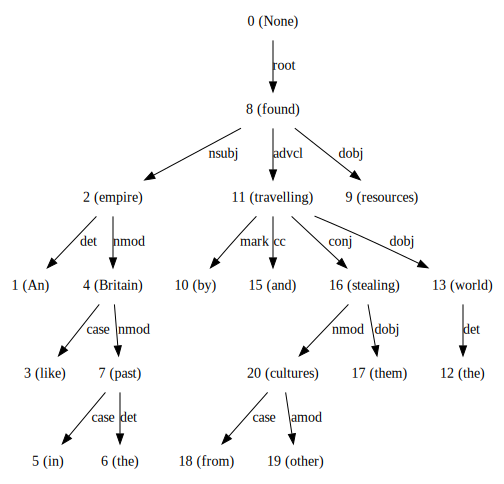

In [104]:
ex_tree[0]

# Information extraction (INSTRUCTOR)

Information extraction approaches typically (as here, with Stanford's Open IE engine) ride atop the dependency parse of a sentence. They are a pre-coded example of the type analyzed in the prior. 

In [95]:
ieDF = openIE(text)

Starting OpenIE run
Adding annotator tokenize
Adding annotator ssplit
Adding annotator pos
Loading POS tagger from edu/stanford/nlp/models/pos-tagger/english-left3words/english-left3words-distsim.tagger ... done [0.9 sec].
Adding annotator lemma
Adding annotator depparse
Loading depparse model file: edu/stanford/nlp/models/parser/nndep/english_UD.gz ... 
PreComputed 99996, Elapsed Time: 16.684 (s)
Initializing dependency parser ... done [18.4 sec].
Adding annotator natlog
Adding annotator openie
Loading clause splitter from edu/stanford/nlp/models/naturalli/clauseSearcherModel.ser.gz ... done [0.0149 seconds]
Processing file: /tmp/tmp98exllr1
All files have been queued; awaiting termination...
DONE processing files. 0 exceptions encountered.



`openIE()` prints everything stanford core produces and we can see from looking at it that initializing the dependency parser takes most of the time, so calling the function will always take at least 12 seconds.

In [96]:
ieDF

,certainty,subject,verb,object
0,1.0,elephant,is in,my pajamas
1,1.0,I,saw,elephant in my pajamas
2,1.0,I,saw,elephant
3,1.0,quick brown fox,jumped over,lazy dog
4,1.0,quick brown fox,jumped over,dog
5,1.0,quick fox,jumped over,dog
6,1.0,fox,jumped over,dog
7,1.0,brown fox,jumped over,lazy dog
8,1.0,brown fox,jumped over,dog
9,1.0,quick fox,jumped over,lazy dog


No buffalos (because there were no verbs), but the rest is somewhat promising. Note, however, that it abandoned the key theme of the sentence about the tragic Trayvon Martin death ("fatally shot"), likely because it was buried so deeply within the complex phrase structure. This is obviously a challenge. 

## <span style="color:red">*Your thoughts (Interpret Instructor IE)*</span>

<span style="color:red">How would you extract relevant information about the Trayvon Martin sentence directly from the dependency parse (above)? Code an example here. (For instance, what compound nouns show up with what verb phrases within the sentence?)

In the context of the Trayvon Martin sentence, in order to discover what compound nouns show up with what verb phrases within the sentence, I would first discover all of the unique compound nouns within that sentence, and then see which verb phrases occur with them.

In [97]:
# Extract only the Trayvon Martin sentence data
ieDF = ieDF.loc[24:]

# Discover all the compound nouns
# Note that np.unique is not necessary in this case, but it would be 
# useful if a compound noun showed up as a verb and an object
comp_nouns = np.unique(np.union1d(ieDF[ieDF['subject'].str.contains(' ')]['subject'], ieDF[ieDF['object'].str.contains(' ')]['object']))
comp_nouns

array(['African American', 'Trayvon Benjamin Martin'], dtype=object)

In [98]:
cn_dict = {cn: None for cn in comp_nouns}
for cn in comp_nouns:
    verbs = list(np.unique(ieDF[(ieDF['subject'] == cn) | (ieDF['object'] == cn)]['verb']))
    cn_dict[cn] = verbs


# Here is the dictionary where the keys are the compound nouns and the values are lists of verbs
# that appear with those compound nouns.
cn_dict

{'African American': ['was'],
 'Trayvon Benjamin Martin': ['was',
  'was African American from',
  'was American from']}

## <span style="color:red">*Your Turn (IE on Brexit Replies)*</span>

<span style="color:red">In the cells immediately following, perform open information extraction on a modest subset of texts relevant to your final project. Analyze the relative attachment of several subjects relative to verbs and objects and visa versa? Describe how you would select among these statements to create a database of high-value statements for your project and do it.

We will run information extraction on 5 replies to the Brexit submission.

In [215]:
cmv_ieDF = openIE(cmv_df.sample(n = 5)['each_sentence_is_list'].sum())

Starting OpenIE run
Adding annotator tokenize
Adding annotator ssplit
Adding annotator pos
Loading POS tagger from edu/stanford/nlp/models/pos-tagger/english-left3words/english-left3words-distsim.tagger ... done [1.1 sec].
Adding annotator lemma
Adding annotator depparse
Loading depparse model file: edu/stanford/nlp/models/parser/nndep/english_UD.gz ... 
PreComputed 99996, Elapsed Time: 17.317 (s)
Initializing dependency parser ... done [19.1 sec].
Adding annotator natlog
Adding annotator openie
Loading clause splitter from edu/stanford/nlp/models/naturalli/clauseSearcherModel.ser.gz ... done [0.0155 seconds]
Processing file: /tmp/tmpzn30nm09
All files have been queued; awaiting termination...
DONE processing files. 0 exceptions encountered.



In [216]:
cmv_ieDF

,certainty,subject,verb,object
0,1.000000,It,has,important
1,0.217987,i,spoke,who voted
2,1.000000,trade,flourished in,sea
3,1.000000,Britain,was land,trade commerce flourished
4,1.000000,Britain,was,land
5,1.000000,Britain,was land,trade commerce flourished in Mediterranean sea
6,1.000000,Britain,was land,trade flourished
7,1.000000,Britain,Prior was land,commerce flourished in Mediterranean sea
8,1.000000,Britain,was land,commerce flourished in Mediterranean sea
9,1.000000,Britain,was land,trade commerce flourished in sea


Let's look at the most common subjects.

In [217]:
cmv_ieDF['subject'].value_counts()

Britain                           35
It                                 8
empire                             5
Trade                              4
you                                4
I                                  4
Trades                             4
neo-liberalism                     4
truth                              4
we                                 3
world                              3
us                                 3
it                                 2
trade                              2
something countries                2
process                            2
commerce                           2
ones                               2
i                                  1
We                                 1
Britains advantageous position     1
Leave                              1
Both                               1
Countries                          1
country                            1
Name: subject, dtype: int64

Now the most common objects.

In [218]:
cmv_ieDF['object'].value_counts()

something                                         4
times                                             4
trade flourished in Mediterranean sea             2
past                                              2
time                                              2
steal                                             2
sea                                               2
dog shit                                          2
commerce flourished in sea                        2
us                                                2
trade commerce flourished in sea                  2
places conquer                                    2
trade commerce flourished in Mediterranean sea    2
trade flourished                                  2
major                                             2
commerce flourished                               2
Mediterranean sea                                 2
people                                            2
commerce flourished in Mediterranean sea          2
world       

Let's see the verbs that are most commonly associated with 'you'.

In [219]:
cmv_ieDF[(cmv_ieDF['subject'] == 'you') | (cmv_ieDF['subject'] == 'You')]['verb'].value_counts()

run                      1
run out of               1
eventually run           1
eventually run out of    1
Name: verb, dtype: int64

Let's see the verbs that are most commonly associated with 'EU'

In [169]:
cmv_ieDF[cmv_ieDF['subject'] == 'EU']['verb'].value_counts()

will likely negotiate    4
will negotiate           4
Name: verb, dtype: int64

In order to extract high value statements from this information extraction. A general approach I would take is to find the most comment subjects and objects that are not pronouns, and take a look at the verbs associated with them. For example, above we see that EU is one of the most used subjects, and the associated verb pharses are 'will negotiate' and 'will likely negotiate'.]

However, there does seem to be some difficulty associated with parsing more and more sentences. Indeed, when I attempted to run information extraction on all of the replies to the Brexit submission, even on my own computer, with 16GB ram, Java ran into memory issues. Information extraction, in the context of my project seems like it would on In order to efficiently utilize information extraction over a large volume of text, I would probably want to utilize some form of cluster computing. In this case, some sort of MPI implementation (e.g. mpi4py) would be ideal.

# Memo 



    In this homework assignment, we looked at POS tagging with conditional associations,named entity recognition, parsing, and information extraction. In order to focus on a modest subuset of our corpora (/r/changemyview submissions and first tier comments), I decided to limit the subset of inquiry to comments from a single submission conerning the Brexit vote. 

    In POS tagging, we found that simple things like adjective and noun counts didn't hold a ton of immediately useful information, though their contents can be scanned to confirm some easy assumptions (i.e. our text in this case was on the topic we had explicitly chosen beforehand). Conditional associations were a little more interesting, providing us with contexts of words of interest.

    Named entity recognition helped us to establish the 'players' of the social game (within the context of the analyzed corpora). In this case, the EU and the UK held top spot, with a few other countires referred to.

    Parsing added a whole new set of potentially useful information. Depth of phase trees could be averaged to get an idea of a comment's sentence complexity on average (complexity as judged by the parser, which is not perfect). Additionally, while parts of speech tagging enabled us to slice out contexts with more scalpel like precision, parsing enabled gave us a flexible level of precision in establishing contexts. The added abstraction of verb phrases and noun phrases, along with arbitrarily complex contexts, allowed us to see the verb and noun phrases that contained certain words of interest. The SubRelation fuction also allowed us to pick out certain parts of speech in V/N phrases also with arbitrarily complex contexts.

    Dependency parsing, at least as shown in the parsing section, did not have as many uses independent of information extraction. Information extraction sat on top of dependency parsing, and took up a fair amount of time and memory. (Information extraction could not be run on my computer even with only 20 comments without running out of memory.) However, the highly interpretable subject/verb/object labelling might be useful if run over more data.